# Homework 6

This notebook provides some skeleton code to get you started on the homework. Add in your own code and markdown cells to answer the homework questions. If you want to submit the notebook as a PDF, make sure your code and markdowns are clear and concise to make grading easy for the TAs.

This notebook can be opened in Colab 

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/zlisto/social_media_analytics/blob/main/HW6.ipynb)


Before starting, select "Runtime->Factory reset runtime" to start with your directories and environment in the base state.

If you want to save changes to the notebook, select "File->Save a copy in Drive" from the top menu in Colab. This will save the notebook in your Google Drive.

For all plots, make sure your axes have nice labels with easy to read fontsizes, otherwise points will be deducted.

# Clones, Installs, and Imports


In [ ]:
!git clone https://github.com/zlisto/social_media_analytics

import os
os.chdir("social_media_analytics")

!pip install -r requirements.txt

import networkx as nx
import networkx.algorithms.community as nx_comm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scripts.communities import spectral_communities



Cloning into 'social_media_analytics'...
remote: Enumerating objects: 327, done.
remote: Counting objects: 100% (327/327), done.
remote: Compressing objects: 100% (244/244), done.
remote: Total 327 (delta 181), reused 222 (delta 79), pack-reused 0
Receiving objects: 100% (327/327), 32.46 MiB | 10.43 MiB/s, done.
Resolving deltas: 100% (181/181), done.
Checking out files: 100% (43/43), done.
     |████████████████████████████████| 58 kB 3.8 MB/s 
     |████████████████████████████████| 3.8 MB 17.6 MB/s 
     |████████████████████████████████| 86 kB 6.2 MB/s 
     |████████████████████████████████| 1.6 MB 51.1 MB/s 
     |████████████████████████████████| 6.5 MB 41.7 MB/s 
     |████████████████████████████████| 596 kB 27.1 MB/s 
     |████████████████████████████████| 895 kB 56.6 MB/s 
     |████████████████████████████████| 67 kB 4.4 MB/s 
     |████████████████████████████████| 1.1 MB 36.4 MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97738 sha2

# Problem 1. Modularity Communities (42 pts) 



## 1. (2 points) Load Network

Load the following network in the file `"data/friends_network_realDonaldTrump.pickle"`. This is the follower network of all the people followed by former President Donald Trump, who no longer is on Twitter.

In [ ]:
#filename of follower network
fname_following = f"data/friends_network_realDonaldTrump.pickle"

G = nx.read_gpickle(fname_following)

nv = G.number_of_nodes()
ne = G.number_of_edges()
print(f"Network has {nv} nodes and {ne} edges")



Network has 46 nodes and 857 edges


## 2. (10 points) Find Modularity Communities

Calculate the modularity based communities for the network and put the results in a dataframe with a `screen_name` and a `community` column.  How many communities did you find?  




In [ ]:
Comm = nx_comm.greedy_modularity_communities(G.to_undirected())
C = []
V = []
for count,comm in enumerate(Comm):
    for v in comm:
        C.append(count)
        V.append(v)
        
df_mod = pd.DataFrame({'screen_name':V, 'community':C})
df_mod.head()

ncomm_mod = len(df_mod.community.unique())
print(f"{ncomm_mod} modularity communities")


3 modularity communities


## 3. (12 points) Community Statistics

What is maximum, minimum, and mean community size?



In [ ]:
df_mod_size = df_mod.groupby(by='community',as_index=False).count()
df_mod_size = df_mod_size.rename(columns={"screen_name":'size'})
size_min = df_mod_size["size"].min()
size_max =  df_mod_size["size"].max()
size_mean =  df_mod_size["size"].mean()

print(f"Minimum community size = {size_min:.3f} nodes")
print(f"Maximum community size = {size_max:.3f} nodes")
print(f"Mean community size = {size_mean:.3f} nodes")

Minimum community size = 3.000 nodes
Maximum community size = 28.000 nodes
Mean community size = 15.333 nodes


## 4. (8 points) Plot Community Size

Make a bar plot of the size of each community.  Make sure you label your axes with readable font.

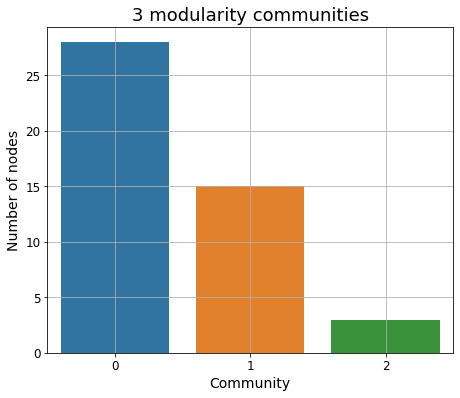

In [ ]:
#plot modularity community sizes
fig = plt.figure(figsize = (16,6))
plt.subplot(1,2,1)
ax = sns.countplot(data=df_mod, x="community")
plt.xlabel("Community", fontsize = 14)
plt.ylabel("Number of nodes", fontsize = 14)
plt.title(f"{ncomm_mod} modularity communities", fontsize = 18)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

plt.grid()
plt.show()

## 5. (10 points) Draw Network

Draw the network with nodes colored by their modularity community membership.  Choose colors that look very different from each other.

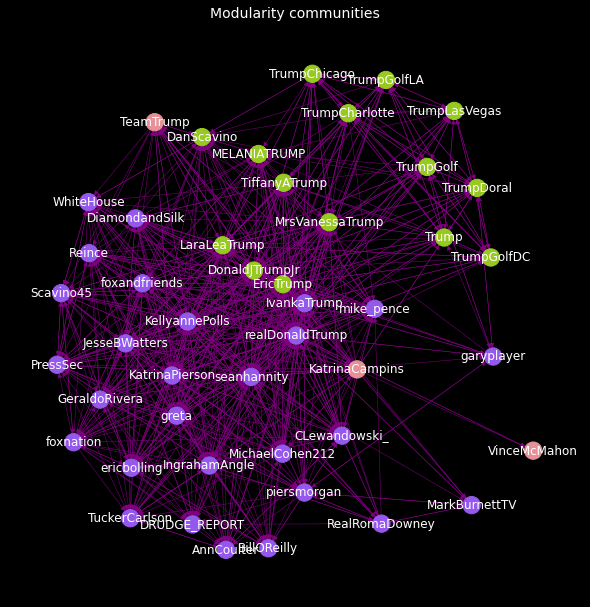

In [ ]:
Colors = [np.random.uniform(0,1,3) for _ in range(100)]
node_color_mod = [Colors[df_mod.community[df_mod.screen_name==node].values[0]] for node in G.nodes()]


pos = nx.kamada_kawai_layout(G)  #position of each node in the network

edge_color = 'purple'
background_color = 'black'
edge_width = .5
node_size = 300

#Draw the network, with labels    
fig = plt.figure(figsize=(8,8))
nx.draw(G, pos, node_color = node_color_mod, 
        width= edge_width, 
        edge_color=edge_color,
        node_size=node_size,
       with_labels=True,
        font_color = 'white')
fig.set_facecolor(background_color)
plt.title("Modularity communities",color = 'white',fontsize = 14)
plt.show()


# Problem 2. Spectral Clustering Communities (64 pts)



## 1. (2 points) Load Network

Load the following network in the file `"data/friends_network_realDonaldTrump.pickle"`. 

In [ ]:
#filename of follower network
fname_following = f"data/friends_network_realDonaldTrump.pickle"

G = nx.read_gpickle(fname_following)

nv = G.number_of_nodes()
ne = G.number_of_edges()
print(f"Network has {nv} nodes and {ne} edges")

Network has 46 nodes and 857 edges


## 2. (20 points) Find Spectral Clustering Communities

Calculate spectral clustering communities for each value of `k` between 2 and 11.  Plot the modularity of each set of communities versus `k`, with nice axis labels.  For which value of `k` is the modularity the highest?

k=2, modularity = 0.080
k=3, modularity = 0.080
k=4, modularity = 0.079
k=5, modularity = 0.095
k=6, modularity = 0.069
k=7, modularity = 0.055
k=8, modularity = 0.046
k=9, modularity = 0.044
k=10, modularity = 0.042
k=11, modularity = 0.053

best k = 5, modularity = 0.09


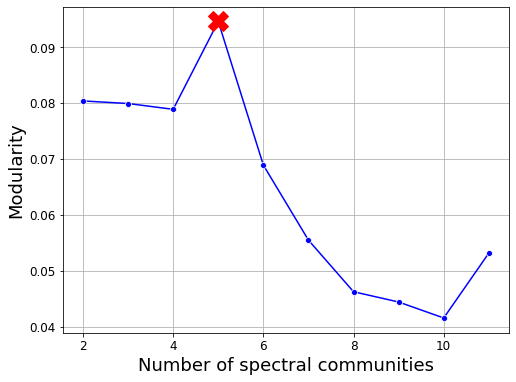

In [ ]:
#k = 3
#df_spec = spectral_communities(G,k)

#ncomm_spec = len(df_spec.community.unique())
#print(f"{ncomm_spec} spectral communities")


K = np.arange(2,12,1)
Mod = []
kbest = 0
mod_best = -1e10
for k in K:
    df_community = spectral_communities(G,k)  #find spectral communities
    #create list of lists of community members
    C = []
    for community_index in df_community.community.unique():
        community = df_community.screen_name[df_community.community==community_index].tolist()
        C.append(community)
    mod = nx_comm.modularity(G.to_undirected(), C)  #calculate modularity of communities
    Mod.append(mod)
 
    print(f"k={k}, modularity = {mod:.3f}")

    #keep track of the best modularity and corresponding k
    if mod>mod_best:
        mod_best = mod
        kbest = k

print(f"\nbest k = {kbest}, modularity = {mod_best:.2f}")

df_k_mod = pd.DataFrame({'k':K,'modularity':Mod})

fig = plt.figure(figsize = (8,6))
sns.lineplot(data = df_k_mod, x = 'k',y = 'modularity',marker = 'o',color = 'blue')
plt.plot(kbest,mod_best,marker = 'X',color = 'red',markersize = 20)

plt.xlabel("Number of spectral communities",fontsize = 18)
plt.ylabel("Modularity",fontsize = 18)
plt.grid()
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.show()
plt.show()

## 3. (10 points) Bar Plot of Community Sizes for Best Communities

For the set of spectral clustering communities with the highest modularity, make a bar plot of the size of each community.  Make sure you have nice axis labels.

5 spectral communities


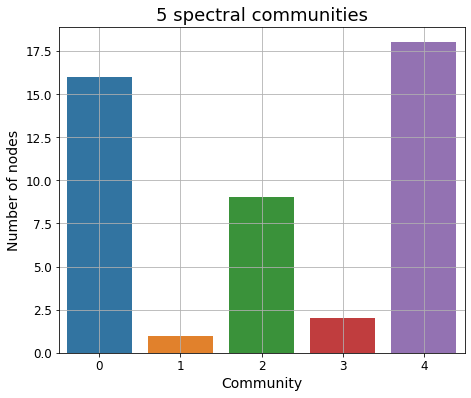

In [ ]:
k = 5
df_spec = spectral_communities(G,k)

ncomm_spec = len(df_spec.community.unique())
print(f"{ncomm_spec} spectral communities")
#plot spectral community sizes
fig = plt.figure(figsize = (16,6))
plt.subplot(1,2,1)
ax = sns.countplot(data=df_spec, x="community")
plt.xlabel("Community", fontsize = 14)
plt.ylabel("Number of nodes", fontsize = 14)
plt.title(f"{ncomm_spec} spectral communities", fontsize = 18)
plt.grid()
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.show()


## 4. (5 points) Betweenness Centrality

Calculate the betweenness centrality of each node in the network.

In [ ]:
Din = nx.in_degree_centrality(G)
Dout = nx.out_degree_centrality(G)
CC = nx.closeness_centrality(G.reverse())  #reverse edges to match networx convention
BC = nx.betweenness_centrality(G)
EC = nx.eigenvector_centrality(G.reverse(),max_iter = 1000)  #reverse edges to match networx convention

dictionary_list = []
for screen_name in Din.keys():
    row = {'screen_name':screen_name,
          'in_degree_centrality':Din[screen_name],
          'out_degree_centrality':Dout[screen_name],
          'closeness_centrality':CC[screen_name],
          'betweenness_centrality':BC[screen_name],
          'eigenvector_centrality':EC[screen_name]}
    dictionary_list.append(row)
df_centrality = pd.DataFrame(dictionary_list)

## 5. (5 points)  Merge Dataframe of Centralities and Spectral Clustering Communities

Merge the centrality dataframe and the best spectral communities dataframe into a single dataframe.  Print out the first 5 rows of this merged dataframe.

In [ ]:
#merge df_spec with df_centrality into one super dataframe
df = df_spec.merge(df_centrality, left_on='screen_name', right_on='screen_name')
df.head(n=5)

,screen_name,community,in_degree_centrality,out_degree_centrality,closeness_centrality,betweenness_centrality,eigenvector_centrality
0,Trump,2,0.377778,0.333333,0.600000,0.003111,0.111472
1,EricTrump,4,0.800000,0.888889,0.900000,0.065791,0.253040
2,TrumpCharlotte,2,0.288889,0.377778,0.616438,0.002085,0.121363
3,IvankaTrump,4,0.844444,0.888889,0.900000,0.070677,0.248002
4,TrumpGolfDC,2,0.266667,0.288889,0.584416,0.000551,0.101372


## 6. (9 points) Top Centrality Users in Each Community

Who are the top three scoring betweeness centrality users within each spectral community?



In [ ]:
display_max = 3
centrality = 'betweenness_centrality'

print(f"Spectral communities: top {display_max} {centrality}")
for community_index in df["community"].unique():
    df_comm = df[df["community"]==community_index]
    leaders = df_comm.sort_values(by= [centrality], ascending = False).screen_name[0:display_max].tolist()
    print(f"Community {community_index}: leaders = {leaders}")

Spectral communities: top 3 betweenness_centrality
Community 2: leaders = ['Trump', 'TrumpGolf', 'TrumpDoral']
Community 4: leaders = ['realDonaldTrump', 'IvankaTrump', 'EricTrump']
Community 0: leaders = ['LaraLeaTrump', 'KellyannePolls', 'MrsVanessaTrump']
Community 3: leaders = ['RealRomaDowney', 'MarkBurnettTV']
Community 1: leaders = ['VinceMcMahon']


## 7. (3 points) Qualitative Community Analysis

Look up information about the top scoring betweenness centrality users.  Use this information to describe the unifying theme of each spectral clustering community.


Community 2: leaders = ['Trump', 'TrumpGolf', 'TrumpDoral'] 
Trump brandname theme linked with each other.
Community 4: leaders = ['realDonaldTrump', 'IvankaTrump', 'EricTrump']
Trump family theme linked between those names.
Community 0: leaders = ['LaraLeaTrump', 'KellyannePolls', 'MrsVanessaTrump']
KellyannePolls linked those names.
Community 3: leaders = ['RealRomaDowney', 'MarkBurnettTV']
TV shows theme is the unifying theme linked.
Community 1: leaders = ['VinceMcMahon']
outlier but linked with Trump with WWE game theme.

## 8. (10 points) Draw Network with Spectral Clustering Community Colors

Draw the network with nodes colored based on their spectral clustering community membership. Use the value of k that has the highest modularity.

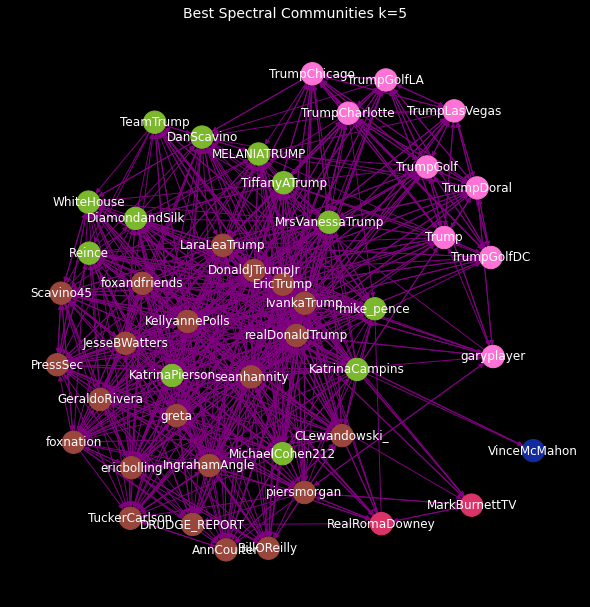

In [ ]:
df_spec_best = spectral_communities(G,kbest)
Colors = [np.random.uniform(0,1,3) for _ in range(100)]
node_color = [Colors[df_spec_best.community[df_spec_best.screen_name==node].values[0]] for node in G.nodes()]

edge_color = 'purple'
background_color = 'black'
edge_width = 1
node_size = 500

   
#Draw the network, with labels    
fig = plt.figure(figsize=(8,8))
nx.draw(G, pos, node_color = node_color, width= edge_width,edge_color=edge_color,node_size=node_size,
       with_labels=True,font_color = 'white')
fig.set_facecolor(background_color)
plt.title(f"Best Spectral Communities k={kbest}",color = 'white',fontsize = 14)
plt.show()